In [2]:
%reset -f

import sys
sys.path.append("../exadata-main/parquet_dataset/query_tool")

import os
import pandas as pd
import numpy as np
import itertools
import datetime
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from query_tool import M100DataClient
from matplotlib import pyplot as plt
from models import *
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
import torch
import torch.nn as nn
import scipy

dataset_path = "../data/m100"
processed_path = "../data"
client = M100DataClient(dataset_path)
 

In [3]:
class LinearNN(nn.Module):
    def __init__(self, feature_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, action_dim)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

In [3]:
# forward second tuple only has to be not None for RNN
# value_function used for PPO calculations (i dont remmebre how sorry sarah)
# warp Model with TorchPolicy

# class CustomModel(TorchModelV2):
#     def __init__(self, obs_space, action_space, num_outputs, model_config, name):
#         super().__init__(obs_space, action_space, num_outputs, model_config, name)
#         self.num_outputs = int(np.product(self.obs_space.shape))
#         self._last_batch_size = None
#         self.fc1 = nn.Linear(feature_dim, hidden_dim)
#         self.bn1 = nn.BatchNorm1d(hidden_dim)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.5)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
#         self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
#         self.fc3 = nn.Linear(hidden_dim // 2, action_dim)
# 
#     # Implement your own forward logic, whose output will then be sent
#     # through an LSTM.
#     def forward(self, input_dict, state, seq_lens):
#         obs = input_dict["obs_flat"]
#         # Store last batch size for value_function output.
#         self._last_batch_size = obs.shape[0]
#         x = self.relu(self.bn1(self.fc1(x)))
#         x = self.dropout(x)
#         x = self.relu(self.bn2(self.fc2(x)))
# 
#         
#         return self.fc3(x), []
# 
#     def value_function(self):
#         return torch.from_numpy(np.zeros(shape=(self._last_batch_size,)))

# def train(model, trainloader, optimizer, loss_fn, epochs, scheduler=None, batches=-1):
#     device = "cuda:0" if torch.cuda.is_available() else "cpu"
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     model.train()
#     for e in range(epochs):
#         # Iterating over data to carry out training step
#         for ii, (inputs, labels) in enumerate(trainloader):
#             if batches == ii:
#                 del inputs, labels
#             if batches != -1 and ii >= batches:
#                 break
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outs = model.forward(inputs)
#             outs, labels = torch.squeeze(outs), torch.squeeze(labels)
#             loss = loss_fn(outs, labels)
#             outputs = model(inputs)
#             loss = loss_fn(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             del inputs, labels, outs
#         if scheduler:
#             scheduler.step()
#             if scheduler:
#                 scheduler.step()
#         print(f"Epoch {e+1}/{epochs}, Loss: {loss.item()}")
#     model.eval()
# 
# def train_epoch(model, trainloader, optimizer, loss_fn, scheduler=None, n_batches=-1):
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     model.to(device)
#     model.train()
#     losses = []
#     # Iterating over data to carry out training step
#     for ii, (inputs, labels) in enumerate(trainloader):
#         if n_batches == ii:
#             del inputs, labels
#             break
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outs = model.forward(inputs)
#         outs, labels = torch.squeeze(outs), torch.squeeze(labels)
#         loss = loss_fn(outs, labels)
#         losses.append(loss.detach().cpu())
#         loss.backward()
#         optimizer.step()
#         del inputs, labels, outs
#     if scheduler:
#         scheduler.step()
# 
#     model.eval()
#     return losses
# 
# def test_epoch(model, testloader, loss_fn, n_batches=-1):
#     device = "cuda:0" if torch.cuda.is_available() else "cpu"
#     model.eval()
#     losses = []
#     with torch.no_grad():
#         # Iterating over data to carry out training step
#         for ii, (inputs, labels) in enumerate(testloader):
#             if n_batches == ii:
#                 del inputs, labels
#                 break
# 
#             inputs, labels = inputs.to(device), labels.to(device)
#             outs = model.forward(inputs)
#             outs, labels = torch.squeeze(outs), torch.squeeze(labels)
#             loss = loss_fn(outs, labels)
#             losses.append(loss)
#             del inputs, labels, outs
# 
#     model.eval()
#     return losses

In [11]:
class LinearNN(nn.Module):
    def __init__(self, feature_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(feature_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, action_dim)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        return self.fc3(x)

def train_epoch(model, trainloader, optimizer, loss_fn, scheduler=None, n_batches=-1):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    losses = []
    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(trainloader):
        if n_batches == ii:
            del inputs, labels
            break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outs = model.forward(inputs)
        outs, labels = torch.squeeze(outs), torch.squeeze(labels)
        loss = loss_fn(outs, labels)
        losses.append(loss.detach().cpu())
        loss.backward()
        optimizer.step()
        del inputs, labels, outs
    if scheduler:
        scheduler.step()

    model.eval()

    return losses

def test_epoch(model, testloader, loss_fn, n_batches=-1):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model.to(device)

    model.eval()
    losses = []
    with torch.no_grad():
        # Iterating over data to carry out training step
        for ii, (inputs, labels) in enumerate(testloader):
            if n_batches == ii:
                del inputs, labels
                break

            inputs, labels = inputs.to(device), labels.to(device)
            outs = model.forward(inputs)
            outs, labels = torch.squeeze(outs), torch.squeeze(labels)
            loss = loss_fn(outs, labels)
            losses.append(loss.cpu())
            del inputs, labels, outs

    model.eval()
    return losses


In [5]:
#TODO FOR BOTH: TIMESTAMP INDICES

def extract_with_nodes(feature_list, index, nodes_of_interest, columns, year_month, n_rows = None, by_indices = None):
    node_dfs = []
    for f in feature_list: 
        query_df = client.query(f, 
                      columns=columns,
                      year_month=year_month)   
        query_df.dropna(inplace=True)
        node_list = query_df["node"].to_numpy().astype(np.int32)
        for noi in nodes_of_interest:
            idxs = np.where(node_list == noi, True, False)
            nodes = query_df.iloc[idxs]
            node_values = nodes["value"].values
            
            node_df = pd.DataFrame(index=nodes[index])
            new_name = str(noi) + "_" + str(f)
            node_df[new_name] = nodes["value"].values
            node_dfs.append(node_df)
            
    plugin_df=pd.concat(node_dfs, axis=1, join="inner")
    return plugin_df

def extract_without_nodes(feature_list, index, columns, year_month, n_rows=None, by_indices=None):
    dfs = []
    for f in feature_list: 
        query_df = client.query(f, 
                      columns=columns,
                      year_month=year_month)   
        query_df.dropna(inplace=True)
        df = pd.DataFrame(index=query_df[index])
        for c in columns:
            if c != index: #dont create column for index
                df[f] = query_df[c].values
        if by_indices is not None:
            df = df[df.index.isin(by_indices)]
        elif n_rows:
            df = df.iloc[:n_rows]
        df = df.loc[~df.index.duplicated(), :]
        dfs.append(df)
        
    plugin_df=pd.concat(dfs, axis=1, join="inner")
    return plugin_df
    
def make_df(features, columns, index, year_month, nodes_of_interest = None, n_rows = None, by_indices=None):
    assert n_rows is not None or by_indices is not None
    if "node" in columns:
        assert nodes_of_interest != None
        return extract_with_nodes(features, index,  nodes_of_interest, columns, year_month,n_rows = n_rows, by_indices=by_indices)
    else:
        return extract_without_nodes(features, index, columns, year_month, n_rows = n_rows, by_indices=by_indices)
#ipmi collects physical/hardware properties of nodes
def get_rack_nodes(rack_num):
    assert rack_num < 49
    return [i for i in range(rack_num*20, (rack_num+1)*20)]

In [6]:
"""Cell purpose: pull desired features from plugins"""
ipmi_features = ["ambient"]
ipmi_columns = ["timestamp", "node", "value"]

vertiv_features = ["Ext_Air_Sensor_A_Temperature", "Ext_Air_Sensor_A_Humidity", "Ext_Air_Sensor_C_Temperature", "Ext_Air_Sensor_C_Humidity"]
vertiv_labels = ["Supply_Air_Temperature_Set_Point", "Fan_Speed"]
vertiv_columns = ["timestamp", "value"]

weather_features = ["temp"]
weather_columns = ["timestamp", "value"]

logics_features = ["Tot_cdz", "pt", "pit", "Tot_chiller", "Tot_qpompe"]
logics_columns = ["timestamp", "value"]

index = "timestamp"
n_rows = 500000
nodes_of_interest = [i*20 for i in range(49)]
year_month = ["22-02"]

ipmi_df=make_df(ipmi_features, ipmi_columns, index,  year_month, nodes_of_interest=nodes_of_interest, n_rows = n_rows)
ipmi_df.to_csv(os.path.join(processed_path, "ipmi.csv"))
by_indices = ipmi_df.index
del ipmi_df
# 
logics_df=make_df(logics_features, logics_columns,index,  year_month, by_indices = by_indices)
logics_df.to_csv(os.path.join(processed_path, "logics.csv"))
del logics_df

weather_df = make_df(weather_features, weather_columns,index,   year_month, by_indices=by_indices)
weather_df.to_csv(os.path.join(processed_path, "weather.csv"))
del weather_df
vertiv_df = make_df(vertiv_features, vertiv_columns, index,year_month, nodes_of_interest=nodes_of_interest, by_indices=by_indices)
vertiv_df.to_csv(os.path.join(processed_path, "vertiv.csv"))
del vertiv_df
vertiv_labels = make_df(vertiv_labels, vertiv_columns, index,  year_month, nodes_of_interest=nodes_of_interest, by_indices=by_indices)
vertiv_labels.to_csv(os.path.join(processed_path, "vertiv_labels.csv"))
del vertiv_labels



Retrieving data of type: float
Retrieving data of type: float
Retrieving data of type: int32
Retrieving data of type: int32
Retrieving data of type: float
Retrieving data of type: float
Retrieving data of type: float
Retrieving data of type: float
Retrieving data of type: float
Retrieving data of type: float
Retrieving data of type: float
Retrieving data of type: float
Retrieving data of type: float


In [5]:
weather_df = pd.read_csv(os.path.join(processed_path, "weather.csv"))
vertiv_df = pd.read_csv(os.path.join(processed_path, "vertiv.csv"))
vertiv_labels = pd.read_csv(os.path.join(processed_path, "vertiv_labels.csv"))
ipmi_df = pd.read_csv(os.path.join(processed_path, "ipmi.csv"))
logics_df = pd.read_csv(os.path.join(processed_path, "logics.csv"))

weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"]).dt.round("min")
vertiv_df["timestamp"] = pd.to_datetime(weather_df["timestamp"]).dt.round("min")
vertiv_labels ["timestamp"] = pd.to_datetime(weather_df["timestamp"]).dt.round("min")
ipmi_df["timestamp"] = pd.to_datetime(weather_df["timestamp"]).dt.round("min")
logics_df["timestamp"] = pd.to_datetime(weather_df["timestamp"]).dt.round("min")

plugin_dfs = [ipmi_df, weather_df, vertiv_df, logics_df, vertiv_labels]

df = plugin_dfs[0].drop("timestamp", axis=1)
for d in plugin_dfs[1:]:
    df = df.merge(d.drop("timestamp", axis=1), left_index=True, right_index=True)
df

#notes: we lose a lot of measurements because timestamps do not overlap. We might want to define an acceptabel margin

,0_ambient,20_ambient,40_ambient,60_ambient,80_ambient,100_ambient,120_ambient,140_ambient,160_ambient,180_ambient,...,Ext_Air_Sensor_A_Humidity,Ext_Air_Sensor_C_Temperature,Ext_Air_Sensor_C_Humidity,Tot_cdz,pt,pit,Tot_chiller,Tot_qpompe,Supply_Air_Temperature_Set_Point,Fan_Speed
0,21.8,20.6,22.6,23.6,24.0,23.6,24.8,25.4,24.6,24.8,...,27.8,7.5,68.1,20.6,376184,247160,169.3,20.8,15.0,60.0
1,21.8,20.6,22.4,23.6,24.0,23.6,24.8,25.4,24.6,24.8,...,28.4,8.5,63.5,15.4,372221,245840,171.5,21.1,15.0,60.0
2,21.8,20.8,22.4,23.4,23.8,23.6,24.8,25.4,24.6,24.8,...,27.6,8.3,63.2,15.6,373350,247200,117.1,20.9,15.0,60.0
3,21.6,21.0,22.4,23.4,23.8,23.4,24.6,25.2,24.6,24.8,...,31.8,10.0,66.5,15.7,359431,245760,170.0,20.9,15.0,60.0
4,21.6,21.0,22.4,23.2,23.6,23.4,24.6,25.2,24.6,24.8,...,28.2,8.6,65.1,15.9,376573,246360,169.6,21.1,15.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838,21.6,18.8,21.2,22.2,23.0,23.2,25.0,25.6,24.2,24.6,...,11.0,4.9,34.2,27.2,363412,245480,111.6,21.0,18.0,82.0
839,21.4,18.8,21.2,22.2,23.0,23.2,25.0,25.6,24.2,24.6,...,11.0,4.9,34.2,17.3,336417,246280,170.8,20.9,18.0,80.0
840,21.4,18.8,21.2,22.2,23.0,23.2,25.0,25.6,24.2,24.6,...,10.9,4.9,34.1,27.5,363279,246080,116.4,20.7,18.0,79.0
841,21.2,18.8,21.2,22.2,22.8,23.2,25.0,25.6,24.2,24.6,...,10.9,4.9,34.1,22.4,378839,245400,116.3,20.8,18.0,79.0


In [8]:
df.index[0]

0

In [6]:
"""Cell purpose: preprocess and/or merge data as desired"""
# 
# feature_list = itertools.chain(ipmi_features, weather_features, vertiv_features)
# label_list = itertools.chain(vertiv_labels) 
nodes_of_interest = [i*20 for i in range(49)]
ipmi_features = [str(noi) + "_ambient" for noi in nodes_of_interest]
feature_list = ["Ext_Air_Sensor_A_Temperature", "Ext_Air_Sensor_A_Humidity", "Ext_Air_Sensor_C_Temperature", "Ext_Air_Sensor_C_Humidity", "Tot_cdz", "pt", "pit", "Tot_chiller", "Tot_qpompe", "temp"]
for noi in ipmi_features: feature_list.append(noi)
label_list = ["Supply_Air_Temperature_Set_Point", "Fan_Speed"]

train_df, test_df = train_test_split(df)
train_df, test_df = train_df.iloc[:-1], test_df.iloc[1:] #align t and t+1
train_features, test_features = train_df[feature_list], test_df[feature_list]
train_labels, test_labels = train_df[label_list], test_df[label_list]



In [7]:
# Will have to make work with timestamp indexign later
class M100Data(Dataset):
    def __init__(self, feature_df, label_df, transform = None, label_transform = None):
        self.feature_df = feature_df
        self.label_df = label_df
        self.feature_dim = self.feature_df.shape[1]
        self.label_dim = self.label_df.shape[1]
        self.transform = transform
        self.label_transform = label_transform
        
    def __len__(self):
        return self.feature_df.shape[0]

    def __getitem__(self, idx):
        feature = torch.as_tensor(self.feature_df.iloc[idx].values, dtype=torch.float32)
        label = torch.as_tensor(self.label_df.iloc[idx].values, dtype=torch.float32)
        return feature, label
    
train_ds = M100Data(train_features, train_labels)
trainloader = DataLoader(train_ds, batch_size = 8, shuffle = True)

test_ds = M100Data(test_features, test_labels)
testloader = DataLoader(test_ds, batch_size=2)

In [16]:
epochs = 10
model = LinearNN(train_ds.feature_dim, train_ds.label_dim)
optimizer = torch.optim.SGD(model.parameters(), 1e-3)
loss_fn = torch.nn.MSELoss()

train_losses, test_losses = [], []
for _ in range(epochs):
    train_losses.append(train_epoch(model, trainloader, optimizer, loss_fn))
    test_losses.append(test_epoch(model, testloader, loss_fn))
train_losses = np.array(train_losses)
test_losses = np.array(test_losses)

In [ ]:
train_losses.shape
test_losses.shape

In [23]:
def plot_avg_epoch_loss(train_losses, test_losses):
    assert len(train_losses) == len(test_losses) #num of epochs should be the same
    avg_train_losses = np.mean(train_losses, axis=1)
    avg_test_losses = np.mean(test_losses, axis=1)
    timesteps = [t for t in range(len(avg_train_losses))]
    # colors = iter(plt.cm.viridis(np.linspace(0, 0.5, 2)))
    plt.plot(timesteps, avg_train_losses, c="blue", label="Training loss")
    plt.plot(timesteps[1:], avg_test_losses[1:], c="red", label="Testing loss")
    plt.legend(loc="upper left")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.show()



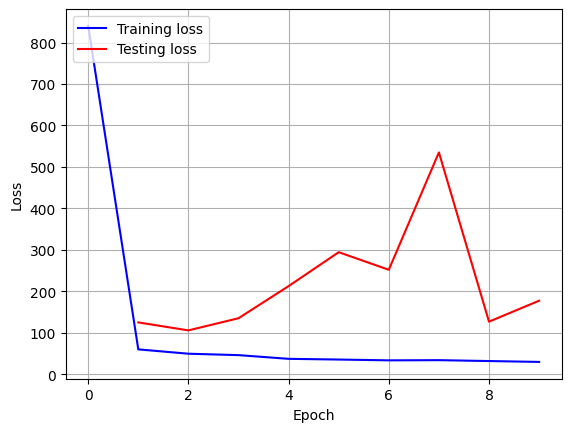

In [24]:
"""Cell purpose: benchmarking"""
plot_avg_epoch_loss(train_losses, test_losses)

In [30]:
torch.save(model.state_dict(), "m100_dict")

In [36]:
d = torch.load("m100_dict")
for p in torch.load("m100_dict"):
    print(p)

fc1.weight
fc1.bias
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
fc2.weight
fc2.bias
bn2.weight
bn2.bias
bn2.running_mean
bn2.running_var
bn2.num_batches_tracked
fc3.weight
fc3.bias
